# Qutrit Machine Learning Optimizaiton 

Author: Bora Basyildiz

## Imports

In [1]:
import torch
import numpy as np
from itertools import permutations
from itertools import product
import matplotlib.pyplot as plt
import random
import os
import shutil
import pandas as pd
from scipy.linalg import expm
import pandas as pd

## Qutrit Fidelity Calculation

In [62]:
#Imports are here too to export block to Wendian script
import torch
import numpy as np
from itertools import product
import os

def Qutrit_ML(J,B,M,input_gate,t,N_iter,pulse_file):
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Aug 16 4:33 2021

    @author: Bora & Alex


    DESC: This function is essentially the qubit optimization done by Alex & I in Joel's experiment. But now we have drives from the |0> -> |1> and |1> -> |2>. 
    We still are generating 2-qubit gates, but the inclusion of qutrit drives minimizes the generation time. See PRA paper promising initial results.  

    UPDATE: Fixed Coupling and retesting removal of two state couping
    """
    #imports

    #Experimental Parameters
    g = 1
    maxFreq = 5*g


    #Pauli Matricies in Qubit Subspace
    sx = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
    sy = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
    sz = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) 
    sxx = np.array([[1,0,0],[0,0,1],[0,1,0]]) 
    syy = np.array([[1,0,0],[0,0,-1j],[0,1j,0]]) 
    id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) 

    
    #Function definitions 

    def sum_pauli(coef, gate):#Sums Pauli gates with coefficients 
        total_pauli =  torch.tensor(np.zeros([3 ** N, 3 ** N]))
        for i in range(0,N):
            pauli_temp = 1
            for j in range(0,i):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            pauli_temp = torch.tensor(np.kron(pauli_temp,gate))
            for j in range(i+1,N):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            #total_pauli = total_pauli + maxFreq*torch.cos(coef[i])*pauli_temp
            total_pauli = total_pauli + coef[i]*pauli_temp
        return total_pauli

    #variable initializations
    N = len(B)
    #torch.manual_seed(random.randint(0,1000))
    torch.manual_seed(9)
    dt = torch.cdouble # datatype and precision
    infidelity_list=torch.zeros([N_iter,1])

    #J coefficients gathering, essentially flattens the array
    J_coef = []
    for i in range(0,len(J) - 1):
        for j in range(0,len(J) - i - 1):
            J_coef.append(J[i,j].item())


    #H0 Generation
    H0 = torch.tensor(np.zeros([3 ** N, 3 ** N]))
    eigen_energies = [0, 5.440, 10.681, 4.994, 10.433, 15.666, 9.832, 15.270, 20.506] # experimentally given by Ray's Group
    for i,e in enumerate(eigen_energies):
        H0[i,i] = float(e)

    #Coupling terms in Hamiltonian (g1(|01><10| + h.c.) + g2(|12><21| + h.c.)
    g1 = 1 #What are the values fo g1 are g2? 
    g2 = 1
    g = [1,2,2]

    zero_state = np.array([1,0,0])
    one_state = np.array([0,1,0])
    two_state = np.array([0,0,1])
    one_coupling = np.kron(np.outer(zero_state,one_state),np.outer(one_state,zero_state))
    one_coupling = one_coupling + one_coupling.conj().T
    two_coupling = np.kron(np.outer(zero_state,two_state),np.outer(two_state,zero_state))
    two_coupling = two_coupling + two_coupling.conj().T
    two_dipole_coupling = + np.kron(np.outer(zero_state,two_state),np.outer(two_state,zero_state))
    two_dipole_coupling = two_dipole_coupling + two_dipole_coupling.conj().T
    H0 = H0 + g[0]*one_coupling + g[1]*two_coupling + g[2]*two_dipole_coupling


    #These are the coefficients we are optimizing
    R = torch.rand([M,4*N], dtype=torch.double) *2*np.pi # Random initialization (between 0 and 2pi)
    R.requires_grad = True # set flag so we can backpropagate
    #Optimizer settings(can be changed & opttimized)
    optimizer = torch.optim.SGD([R], lr = 0.8, momentum=0.99, nesterov=True)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.03, factor=0.3 , patience= 20 )


    #Unitary group generation
    SU = []
    pauli_int = [1,2,3,4]
    perms = list(product(pauli_int,repeat=N))#all permutations of paulis
    #Paul Matrices only in the qubit space 
    sxq = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
    syq = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
    szq = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) 
    idq = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 0]]) 
    for p in perms:#mapping integers to pauli 
        unitary = 1
        for pauli in p:
            if pauli == 1:
                unitary = torch.tensor(np.kron(unitary,sxq),dtype=torch.cdouble)
            elif pauli == 2:
                unitary = torch.tensor(np.kron(unitary,syq),dtype=torch.cdouble)
            elif pauli == 3:
                unitary = torch.tensor(np.kron(unitary,szq),dtype=torch.cdouble)
            elif pauli == 4:
                unitary = torch.tensor(np.kron(unitary,idq),dtype=torch.cdouble)
        SU.append(unitary)

    #prev_infidelity = -1
    for n in range(0,N_iter):
        #Creating Drive Hamilontian
        U_Exp = 1
        for i in range(0,N):
            U_Exp = torch.tensor(np.kron(U_Exp,id),dtype=dt)#initializing unitary
        for m in range(0,M):#Product of pulses
            pulse_coef = R[m]
            H1 = sum_pauli(pulse_coef[:N],sx) + sum_pauli(pulse_coef[N:2*N],sy) + sum_pauli(pulse_coef[2*N:3*N],sxx) + sum_pauli(pulse_coef[3*N:4*N],syy) 
            U_Exp = torch.matmul(torch.matrix_exp(-1j*(H0+H1)*t/M),U_Exp)

        #Fidelity calulcation given by Nielsen Paper
        fidelity = 0
        d = 2**N
        
        for U in SU:
            eps_U = torch.matmul(torch.matmul(U_Exp,U),(U_Exp.conj().T))
            target_U = torch.matmul(torch.matmul(input_gate,(U.conj().T)),(input_gate.conj().T))
            tr = torch.trace(torch.matmul(target_U,eps_U))
            fidelity = fidelity + tr
        fidelity = abs(fidelity + d*d)/(d*d*(d+1))    
        infidelity = 1 - fidelity
        infidelity_list[n] = infidelity.detach()
        infidelity.backward()

        #Printing statement
        if (n+1)%100==0: print('Itertation ', str(n+1), ' out of ', str(N_iter), 'complete. Avg Infidelity: ', str(infidelity.item()))

        #optimizer 
        optimizer.step()
        scheduler.step(infidelity)
        optimizer.zero_grad()

        if 1 - infidelity_list[n] >= 99.99: #Stopping condition for high fidelity iterations
            return infidelity_list.min().item()

    tmin = np.pi/4
    #pulse_file_time = pulse_file + "_time" + str(t/tmin)+"_"
    #np.savetxt(os.path.join(os.getcwd(),"Pulse_Sequences/"+pulse_file+"/" +pulse_file_time+".csv"),R.detach().numpy(),delimiter=",") 
    return infidelity_list.min().item()

## Qutrit Testing

In [64]:
CNOT_qutrit = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
Identity = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])
#pulse_frequencies = fidelity_Qutrit(J,[1,1],24,CNOT_qutrit,np.pi/4,100000)
Qutrit_ML(J,[1,1],16,CNOT_qutrit,np.pi/8,500,"test")

Itertation  100  out of  500 complete. Avg Infidelity:  0.5613338384349953
Itertation  200  out of  500 complete. Avg Infidelity:  0.4720158593164815
Itertation  300  out of  500 complete. Avg Infidelity:  0.4124461881279413


KeyboardInterrupt: 

In [63]:
iSWAP = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,1j,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,1j,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
Qutrit_ML(J,[1,1],16,iSWAP,3*np.pi/4,500,"test")

Itertation  100  out of  500 complete. Avg Infidelity:  -0.06738856877464983
Itertation  200  out of  500 complete. Avg Infidelity:  -0.09340170477404475
Itertation  300  out of  500 complete. Avg Infidelity:  -0.09648294379585165
Itertation  400  out of  500 complete. Avg Infidelity:  -0.09659914656725666


KeyboardInterrupt: 

In [ ]:
def qubitSubspace(gate):
    gate = np.delete(gate,2,0)
    gate = np.delete(gate,2,1)
    return gate[:4,:4]
sxx = np.array([[1,0,0],[0,0,1],[0,1,0]]) 
id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) 
print(qubitSubspace(np.kron(id,sxx)))

## Graph Generation

/Users/borabasyildiz/opt/anaconda3/envs/py7/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


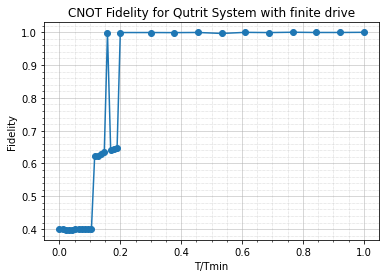

In [27]:
#Qutrit Subsystem Graph Generation 

#Gate and ferromagnetic variables
CNOT_qutrit = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])

#Iteration variables 
Fidelities = []
Times = []
points = np.linspace(0,0.2*np.pi/4,20)
points = np.append(points, np.linspace(0.3*np.pi/4,np.pi/4,10))
iteration_count = 5000

#File Creation 
Pulse_file = "CNOT_Qutrit_Experimental_noDiag"
try:
    os.makedirs("Pulse_Sequences/"+Pulse_file)
except:
    shutil.rmtree("Pulse_Sequences/"+Pulse_file)
    os.makedirs("Pulse_Sequences/"+Pulse_file)

#Generating Points
for t in points:
    Times.append(t/(np.pi/4))
    Fidelities.append(1 - Qutrit_ML(J,[1,1],8,CNOT_qutrit,t,iteration_count,Pulse_file))

#Saving Fidelities
np.savetxt(os.path.join(os.getcwd(),"Data",Pulse_file+".csv"),Fidelities,delimiter=",")

#plotting 
plt.plot(Times,Fidelities,'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("CNOT Fidelity for Qutrit System with finite drive")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()
plt.savefig(os.path.join(os.getcwd(),"Figures",Pulse_file+".pdf"), format="pdf")

In [3]:
pulses = np.loadtxt("Pulse_Sequences/CNOT_Qutrit_Experimental_couplingOn/CNOT_Qutrit_Experimental_couplingOn_time0.37777777777777777_.csv",delimiter=",",dtype=float)

In [34]:
print("For our single qubit drive strength for Dr. Simmonds Hamiltonian, we have the follow description of the generated pulses")
print("Our max pulse is " + str(pulses.max()))
print("The average pulse strength is " + str(pulses.mean()))

For our single qubit drive strength for Dr. Simmonds Hamiltonian, we have the follow description of the generated pulses
Our max pulse is 21.60859210012844
The average pulse strength is 2.8030343650743914


In [5]:
pulseDF = pd.DataFrame(pulses.flatten())

NameError: name 'pulseDF' is not defined

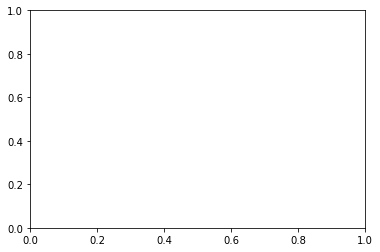

In [4]:
fig, ax = plt.subplots(figsize = (6,4))
pulseDF.plot(kind = "hist", density = True, bins = 15) # change density to true, because KDE uses density
    # Plot KDE
pulseDF.plot(kind = "kde")
plt.show()

<Figure size 432x288 with 0 Axes>

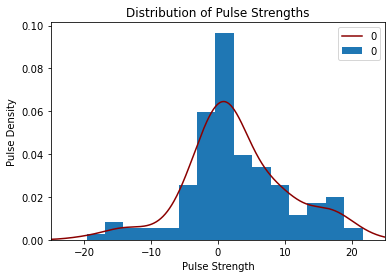

In [6]:
fig=plt.figure()

# Plots #
    # Plot histogram
ax = pulseDF.plot(kind = "hist", density = True, bins = 15) # change density to true, because KDE uses density
    # Plot KDE
pulseDF.plot(kind = "kde",ax=ax,color="DarkRed")

# X #
ax.set_xlim(-25,25)


# Overall #
ax.set_title("Distribution of Pulse Strengths")
ax.set_xlabel("Pulse Strength")
ax.set_ylabel("Pulse Density")

plt.show()

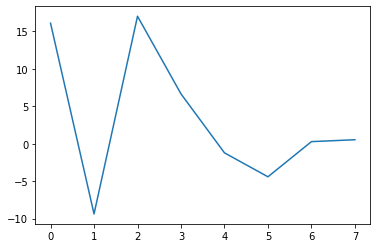

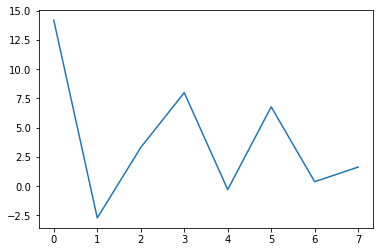

In [13]:
fig = plt.figure()
plt.plot(pulses[0])
fig = plt.figure()
plt.plot(pulses[1])

In [56]:
sx = np.array([[0,1],[1,0]])
id = np.array([[1,0],[0,1]])
zeroState = np.array([1,0])

In [57]:
zeroState = np.array([1,0])
oneState = np.array([0,1])

In [62]:
print(np.outer(zeroState,oneState) + np.outer(oneState,zeroState))

[[0 1]
 [1 0]]


In [65]:
zeroState = np.array([1,0,0])
oneState = np.array([0,1,0])
twoState = np.array([0,0,1])
print(np.outer(zeroState,oneState) + np.outer(oneState,zeroState) + np.outer(twoState,oneState) + np.outer(oneState,twoState))

[[0 1 0]
 [1 0 1]
 [0 1 0]]


In [74]:
H0 = np.zeros([9,9])
eigen_energies = [0, 5.440, 10.681, 4.994, 10.433, 15.666, 9.832, 15.270, 20.506] # experimentally given by Ray's Group
for i,e in enumerate(eigen_energies):
    H0[i,i] = float(e)

#Coupling terms in Hamiltonian (g1(|01><10| + h.c.) + g2(|12><21| + h.c.)
g1 = 1 #What are the values fo g1 are g2? 
g2 = 1
zero_state = np.array([1,0,0])
one_state = np.array([0,1,0])
two_state = np.array([0,0,1])
one_coupling = np.kron(np.outer(zero_state,one_state),np.outer(one_state,zero_state))
one_coupling = one_coupling + one_coupling.conj().T
two_coupling = np.kron(np.outer(one_state,two_state),np.outer(two_state,one_state))
two_coupling = two_coupling + two_coupling.conj().T
H0 = H0 + g1*one_coupling + g2*two_coupling

In [279]:
sx = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
sy = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
sz = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) 
sxx = np.array([[0,0,0],[0,0,1],[0,1,0]]) 
syy = np.array([[0,0,0],[0,0,-1j],[0,1j,0]]) 
id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) 
id2 = np.array([[0, 0, 0],[0, 1, 0],[0, 0, 1]]) 

In [281]:
np.kron(sxx,id)
#Identity should not be 1 in the third diagonal as it lets the sx and sy gates flip from |0> -> |1> and |1> -> |2> 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [ ]:
#IF WE ARE ONLY EVALUATING ON THE QUBIT SPACE, WHY WOULD THE QUTRIT DRIVES MATTER? (Maybe look at Ashabb paper)

In [95]:
print(sxx)

[[0 0 0]
 [0 0 1]
 [0 1 0]]


In [104]:
print(H0)

[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     5.44   0.     1.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    10.681  0.     0.     0.     0.     0.     0.   ]
 [ 0.     1.     0.     4.994  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    10.433  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.    15.666  0.     1.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     9.832  0.     0.   ]
 [ 0.     0.     0.     0.     0.     1.     0.    15.27   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    20.506]]


In [107]:
print(one_coupling + two_coupling)

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [112]:
print(np.kron(sxx,id2))

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]]


In [190]:
#Unitary group generation
SU = []
N = 2
pauli_int = [1,2,3]
perms = list(product(pauli_int,repeat=N))#all permutations of paulis

idq = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 0]]) 
sxq = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
#syq = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
szq = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) 
for p in perms:#mapping integers to pauli 
    unitary = 1
    for pauli in p:
        if pauli == 1:
            unitary = np.kron(unitary,sxq)
        elif pauli == 2:
            unitary = np.kron(unitary,szq)
        elif pauli == 3:
            unitary = np.kron(unitary,idq)
    SU.append(unitary)

In [191]:
for U in SU:
    print(U)

[[0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
[[ 0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]
[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
[[ 0  1  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]
[[ 1  0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  

In [136]:
a = np.array(expm(H0))

In [140]:
for row in a:
    for val in row:
        print(int(val != 0),end = " ")
    print()

1 0 0 0 0 0 0 0 0 
0 1 0 1 0 0 0 0 0 
0 0 1 0 0 0 0 0 0 
0 1 0 1 0 0 0 0 0 
0 0 0 0 1 0 0 0 0 
0 0 0 0 0 1 0 1 0 
0 0 0 0 0 0 1 0 0 
0 0 0 0 0 1 0 1 0 
0 0 0 0 0 0 0 0 1 


In [228]:
#Why dont you do a projection algorithm to do to the qubit space. 
def qubitSubspace(gate):
    gate = np.delete(gate,2,0)
    gate = np.delete(gate,2,1)
    return gate[:4,:4]
    
    

In [229]:
coup = one_coupling + two_coupling
print(coup)
qubitSubspace(coup)

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


array([[0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0]])

In [196]:
coup_test = coup.copy()

In [ ]:
test = np.kron()

In [ ]:
np.delete(coup_test,)

In [197]:
sx = np.array([[0,1],[1,0]])
test_mat = np.kron(sx,sx)

In [198]:
print(test_mat)

[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]


In [218]:
np.delete(test_mat.T,2,1)

array([[0, 0, 1],
       [0, 0, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [221]:
coup2 = np.delete(coup,2,0)

In [224]:
coup3 = np.delete(coup2,2,1)

In [227]:
coup3[:4,:4]

array([[0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0]])

In [242]:
import torch
import numpy as np
from itertools import product
import os

def Qutrit_ML(J,B,M,input_gate,t,N_iter,pulse_file):
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Aug 16 4:33 2021

    @author: Bora & Alex


    DESC: This function is essentially the qubit optimization done by Alex & I in Joel's experiment. But now we have drives from the |0> -> |1> and |1> -> |2>. 
    We still are generating 2-qubit gates, but the inclusion of qutrit drives minimizes the generation time. See PRA paper promising initial results.  

    UPDATE: Fixed Coupling and retesting removal of two state couping
    """
    #imports

    #Experimental Parameters
    g = 1
    maxFreq = 5*g


    #Pauli Matricies in Qubit Subspace
    sx = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
    sy = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
    sz = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) 
    id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 0]]) 
    sxx = np.array([[1,0,0],[0,0,1],[0,1,0]]) 
    syy = np.array([[1,0,0],[0,0,-1j],[0,1j,0]]) 
    idd = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) 

    
    #Function definitions 

    def zero_mat(N):#Generates matrix of zeros
        zero_gate = np.array([[0,0,0],[0,0,0],[0,0,0]])
        init = zero_gate
        if N < 2:
            return 1
        for i in range(0,N - 1):
            zero_gate = torch.tensor(np.kron(zero_gate,init))
        return zero_gate
    
    def sum_pauli(coef, gate):#Sums Pauli gates with coefficients 
        N = len(coef)
        total_pauli = zero_mat(N)
        for i in range(0,N):
            pauli_temp = 1
            for j in range(0,i):
                pauli_temp = torch.tensor(np.kron(pauli_temp,idd))
            pauli_temp = torch.tensor(np.kron(pauli_temp,gate))
            for j in range(i+1,N):
                pauli_temp = torch.tensor(np.kron(pauli_temp,idd))
            #total_pauli = total_pauli + maxFreq*torch.cos(coef[i])*pauli_temp
            total_pauli = total_pauli + coef[i]*pauli_temp
        return total_pauli

    #variable initializations
    N = len(B)
    #torch.manual_seed(random.randint(0,1000))
    torch.manual_seed(9)
    dt = torch.cdouble # datatype and precision
    infidelity_list=torch.zeros([N_iter,1])

    #J coefficients gathering, essentially flattens the array
    J_coef = []
    for i in range(0,len(J) - 1):
        for j in range(0,len(J) - i - 1):
            J_coef.append(J[i,j].item())


    #H0 Generation
    H0 = torch.tensor(zero_mat(N),dtype=torch.cdouble)
    eigen_energies = [0, 5.440, 10.681, 4.994, 10.433, 15.666, 9.832, 15.270, 20.506] # experimentally given by Ray's Group
    for i,e in enumerate(eigen_energies):
        H0[i,i] = float(e)

    #Coupling terms in Hamiltonian (g1(|01><10| + h.c.) + g2(|12><21| + h.c.)
    g1 = g #What are the values fo g1 are g2? 
    g2 = g1
    zero_state = np.array([1,0,0])
    one_state = np.array([0,1,0])
    two_state = np.array([0,0,1])
    one_coupling = np.kron(np.outer(zero_state,one_state),np.outer(one_state,zero_state))
    one_coupling = one_coupling + one_coupling.conj().T
    two_coupling = np.kron(np.outer(one_state,two_state),np.outer(two_state,one_state))
    two_coupling = two_coupling + two_coupling.conj().T
    H0 = H0 + g1*one_coupling + g2*two_coupling


    #These are the coefficients we are optimizing
    R = torch.rand([M,4*N], dtype=torch.double) *2*np.pi # Random initialization (between 0 and 2pi)
    R.requires_grad = True # set flag so we can backpropagate

    #Optimizer settings(can be changed & opttimized)
    lr=0.3#learning rate

    opt = 'SGD'  # Choose optimizer - ADAM, SGD (typical). ADAMW, ADAMax, Adadelta,  
                        # Adagrad, Rprop, RMSprop, ASGD, also valid options.     
    sched = 'Plateau'  # Choose learning rate scheduler - Plateau, Exponential (typical), Step
    
    if opt=='ADAM': optimizer = torch.optim.Adam([R], lr = lr, weight_decay=1e-6)
    elif opt=='ADAMW': optimizer = torch.optim.AdamW([R], lr = lr, weight_decay=0.01)
    elif opt=='ADAMax': optimizer = torch.optim.Adamax([R], lr = lr, weight_decay=0.01)
    elif opt=='RMSprop': optimizer = torch.optim.RMSprop([R], lr = lr, momentum=0.2)
    elif opt=='Rprop': optimizer = torch.optim.Rprop([R], lr = lr)
    elif opt=='Adadelta': optimizer = torch.optim.Adadelta([R], lr = lr) 
    elif opt=='Adagrad': optimizer = torch.optim.Adagrad([R], lr = lr)
    elif opt=='SGD': optimizer = torch.optim.SGD([R], lr = lr, momentum=0.99, nesterov=True)
    elif opt=='ASGD': optimizer = torch.optim.ASGD([R], lr = lr)
    else: optimizer=None; opt='None'
        
    if sched=='Step': scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=N_iter/10, gamma=0.9)
    elif sched=='Exponential': scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    elif sched=='Plateau': scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.03, factor=0.3 , patience= 20 ); loss_in=True; 
    else: scheduler=None; sched='None'

    #Unitary group generation
    SU = []
    pauli_int = [1,2,3,4]
    perms = list(product(pauli_int,repeat=N))#all permutations of paulis
    #Paul Matrices only in the qubit space 
    for p in perms:#mapping integers to pauli 
        unitary = 1
        for pauli in p:
            if pauli == 1:
                unitary = torch.tensor(np.kron(unitary,sx),dtype=torch.cdouble)
            elif pauli == 2:
                unitary = torch.tensor(np.kron(unitary,sy),dtype=torch.cdouble)
            elif pauli == 3:
                unitary = torch.tensor(np.kron(unitary,sz),dtype=torch.cdouble)
            elif pauli == 4:
                unitary = torch.tensor(np.kron(unitary,id),dtype=torch.cdouble)
        SU.append(unitary)

    #prev_infidelity = -1
    for n in range(0,N_iter):
        #Creating Drive Hamilontian
        U_Exp = 1
        for i in range(0,N):
            U_Exp = torch.tensor(np.kron(U_Exp,idd),dtype=dt)#initializing unitary
        for m in range(0,M):#Product of pulses
            pulse_coef = R[m]
            H1 = sum_pauli(pulse_coef[:N],sx) + sum_pauli(pulse_coef[N:2*N],sy) + sum_pauli(pulse_coef[2*N:3*N],sxx) + sum_pauli(pulse_coef[3*N:4*N],syy) 
            U_Exp = torch.matmul(torch.matrix_exp(-1j*(H0+H1)*t/M),U_Exp)

        #Fidelity calulcation given by Nielsen Paper
        fidelity = 0
        d = 2**N
        
        for U in SU:
            eps_U = torch.matmul(torch.matmul(U_Exp,U),(U_Exp.conj().T))
            target_U = torch.matmul(torch.matmul(input_gate,(U.conj().T)),(input_gate.conj().T))
            tr = torch.trace(torch.matmul(target_U,eps_U))
            fidelity = fidelity + tr
        fidelity = abs(fidelity + d*d)/(d*d*(d+1))    
        infidelity = 1 - fidelity
        infidelity_list[n] = infidelity.detach()
        print(infidelity)
        infidelity.backward()

        #Printing statement
        if (n+1)%50==0: 
            print('Itertation ', str(n+1), ' out of ', str(N_iter), 'complete. Avg Infidelity: ', str(infidelity.item()))

        #optimizer 
        if optimizer is not None and scheduler is None:  # Update R
            optimizer.step()
            optimizer.zero_grad()
        elif optimizer is not None and scheduler is not None:
            optimizer.step()
            if loss_in: 
                scheduler.step(infidelity)
            else: 
                scheduler.step()
            optimizer.zero_grad()
        else:
            R.data.sub_(lr*R.grad.data) # using data avoids overwriting tensor object
            R.grad.data.zero_()           # and it's respective grad info
        
        if 1 - infidelity_list[n] >= 99.99: #Stopping condition for high fidelity iterations
            print("Exited here 2")
            return infidelity_list.min().item()

    tmin = np.pi/4

    pulse_file_time = pulse_file + "_time" + str(t/tmin)+"_"
    #np.savetxt(os.path.join(os.getcwd(),"Pulse_Sequences/"+pulse_file+"/" +pulse_file_time+".csv"),R.detach().numpy(),delimiter=",") 
    return infidelity_list.min().item()

In [243]:
CNOT_qutrit = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
Identity = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])
#pulse_frequencies = fidelity_Qutrit(J,[1,1],24,CNOT_qutrit,np.pi/4,100000)
Qutrit_ML(J,[1,1],16,CNOT_qutrit,np.pi/8,500,"test")

/Users/borabasyildiz/opt/anaconda3/envs/py7/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.7633, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7632, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7631, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7629, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7627, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7625, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7622, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7619, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7615, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7611, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7606, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7601, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7596, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7590, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7583, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7577, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7569, dtype=tor

KeyboardInterrupt: 

In [31]:
#Imports are here too to export block to Wendian script
import torch
import numpy as np
from itertools import product
import os
from itertools import permutations

def Qutrit_ML(J,B,M,input_gate,t,N_iter,pulse_file):
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Aug 16 4:33 2021

    @author: Bora & Alex


    DESC: This function is essentially the qubit optimization done by Alex & I in Joel's experiment. But now we have drives from the |0> -> |1> and |1> -> |2>. 
    We still are generating 2-qubit gates, but the inclusion of qutrit drives minimizes the generation time. See PRA paper promising initial results.  

    UPDATE: Fixed Coupling and retesting removal of two state couping
    """
    #imports

    #Experimental Parameters
    g = 1
    maxFreq = 5*g


    #Pauli Matricies in Qubit Subspace
    sx = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
    sy = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
    sz = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) 
    sxx = np.array([[1,0,0],[0,0,1],[0,1,0]]) 
    syy = np.array([[1,0,0],[0,0,-1j],[0,1j,0]]) 
    id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) 

    # Annhilation and Creation Operators (for PRA Hamiltonian)
    annhilate = np.array([[0,1,0],[0,0,np.sqrt(2)],[0,0,0]])
    create = annhilate.T

    
    #Function definitions 
    def sum_pauli(coef, gate):#Sums Pauli gates with coefficients 
        total_pauli =  torch.tensor(np.zeros([3 ** N, 3 ** N]))
        for i in range(0,N):
            pauli_temp = 1
            for j in range(0,i):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            pauli_temp = torch.tensor(np.kron(pauli_temp,gate))
            for j in range(i+1,N):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            total_pauli = total_pauli + coef[i]*pauli_temp
        return total_pauli

    #variable initializations
    N = len(B)
    torch.manual_seed(9)
    dt = torch.cdouble # datatype and precision
    infidelity_list=torch.zeros([N_iter,1])

    #Permutations of coupling 
    N = 2
    id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) 
    # Annhilation and Creation Operators (for PRA Hamiltonian)
    annhilate = np.array([[0,1,0],[0,0,np.sqrt(2)],[0,0,0]])
    create = annhilate.T
    #Permutations of coupling 
    H0 = torch.tensor(np.kron(annhilate + create,annhilate + create))

    #These are the coefficients we are optimizing
    R = torch.rand([M,4*N], dtype=torch.double) *2*np.pi # Random initialization (between 0 and 2pi)
    R.requires_grad = True # set flag so we can backpropagate
    optimizer = torch.optim.SGD([R], lr = 0.8, momentum=0.99, nesterov=True)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.03, factor=0.3 , patience= 20 )


    #Unitary group generation
    SU = []
    pauli_int = [1,2,3,4]
    perms = list(product(pauli_int,repeat=N))#all permutations of paulis
    #Paul Matrices only in the qubit space 
    sxq = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
    syq = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
    szq = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) 
    idq = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 0]]) 
    for p in perms:#mapping integers to pauli 
        unitary = 1
        for pauli in p:
            if pauli == 1:
                unitary = torch.tensor(np.kron(unitary,sxq),dtype=torch.cdouble)
            elif pauli == 2:
                unitary = torch.tensor(np.kron(unitary,syq),dtype=torch.cdouble)
            elif pauli == 3:
                unitary = torch.tensor(np.kron(unitary,szq),dtype=torch.cdouble)
            elif pauli == 4:
                unitary = torch.tensor(np.kron(unitary,idq),dtype=torch.cdouble)
        SU.append(unitary)

    for n in range(0,N_iter):
        #Creating Drive Hamilontian
        U_Exp = 1
        for i in range(0,N):
            U_Exp = torch.tensor(np.kron(U_Exp,id),dtype=dt)#initializing unitary
        for m in range(0,M):#Product of pulses
            pulse_coef = R[m]
            H1 = sum_pauli(pulse_coef[:N],sx) + sum_pauli(pulse_coef[N:2*N],sy) + sum_pauli(pulse_coef[2*N:3*N],sxx) + sum_pauli(pulse_coef[3*N:4*N],syy) 
            U_Exp = torch.matmul(torch.matrix_exp(-1j*(H0+H1)*t/M),U_Exp)

        #Fidelity calulcation given by Nielsen Paper
        fidelity = 0
        d = 2**N
        
        for U in SU:
            eps_U = torch.matmul(torch.matmul(U_Exp,U),(U_Exp.conj().T))
            target_U = torch.matmul(torch.matmul(input_gate,(U.conj().T)),(input_gate.conj().T))
            tr = torch.trace(torch.matmul(target_U,eps_U))
            fidelity = fidelity + tr
        fidelity = abs(fidelity + d*d)/(d*d*(d+1))    
        infidelity = 1 - fidelity
        infidelity_list[n] = infidelity.detach()
        infidelity.backward()

        #Printing statement
        #if (n+1)%100==0: print('Itertation ', str(n+1), ' out of ', str(N_iter), 'complete. Avg Infidelity: ', str(infidelity.item()))

        #optimizer 
        optimizer.step()
        scheduler.step(infidelity)
        optimizer.zero_grad()

        if 1 - infidelity_list[n] >= 99.99: #Stopping condition for high fidelity iterations
            return infidelity_list.min().item()

    #tmin = np.pi/4
    #pulse_file_time = pulse_file + "_time" + str(t/tmin)+"_"
    #np.savetxt(os.path.join(os.getcwd(),"Pulse_Sequences/"+pulse_file+"/" +pulse_file_time+".csv"),R.detach().numpy(),delimiter=",") 
    return infidelity_list.min().item()

In [32]:
CNOT_qutrit = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
Identity = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])
#pulse_frequencies = fidelity_Qutrit(J,[1,1],24,CNOT_qutrit,np.pi/4,100000)
Qutrit_ML(J,[1,1],16,CNOT_qutrit,np.pi/8,500,"test")

Itertation  100  out of  500 complete. Avg Infidelity:  0.45398746010016544


KeyboardInterrupt: 

In [7]:
#Qutrit Subsystem Graph Generation 
CNOT_qutrit = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])

Fidelities = []
Times = []


Fidelities = []
Times = []

points = np.linspace(0,0.2*np.pi/4,20)
points = np.append(points, np.linspace(0.3*np.pi/4,np.pi/4,10))

for t in points:
    Times.append(t/(np.pi/4))
    Fidelities.append(1 - fidelity_subQutrit(J,[1,1],16,CNOT_qutrit,t,5000))

np.savetxt(os.path.join(os.getcwd(),"Data","CNOT_Qutrit2.csv"),Fidelities,delimiter=",")

#plotting 
plt.plot(Times,Fidelities,'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("CNOT Fidelity for Qutrit System")
# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5')
# Customize the minor grid
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()
plt.savefig(os.path.join(os.getcwd(),"Figures","CNOT_Qutrit2.pdf"), format="pdf")

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.4142, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.4142, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4142, 0.0000],
        [1.0000, 0.0000, 1.4142, 0.0000, 0.0000, 0.0000, 1.4142, 0.0000, 2.0000],
        [0.0000, 1.4142, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.4142, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.4142, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)


KeyboardInterrupt: 

In [ ]:
# Tomorrow, take in g vector for coupling coefficents. Look at different values of g2 and look at adding the secondary coupling with the |02><20| + h.c. step. 
#I think the problem is, is that g2 = 1 is not strong enough to introduce much of a speed up. Hence increasing g2 may give a much stronger speed-up 

In [37]:
N = 2
id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) 
# Annhilation and Creation Operators (for PRA Hamiltonian)
annhilate = np.array([[0,1,0],[0,0,np.sqrt(2)],[0,0,0]])
create = annhilate.T
#Permutations of coupling 
H0 = torch.tensor(np.kron(annhilate + create,annhilate + create))

In [38]:
print(H0)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.4142, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.4142, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4142, 0.0000],
        [1.0000, 0.0000, 1.4142, 0.0000, 0.0000, 0.0000, 1.4142, 0.0000, 2.0000],
        [0.0000, 1.4142, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.4142, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.4142, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)


In [44]:
#g1 = 1
#g2 = 1
#g3 = 1
zero_state = np.array([1,0,0])
one_state = np.array([0,1,0])
two_state = np.array([0,0,1])
one_coupling = np.kron(np.outer(zero_state,one_state),np.outer(one_state,zero_state))
one_coupling = one_coupling + one_coupling.conj().T
two_coupling = np.kron(np.outer(one_state,two_state),np.outer(two_state,one_state))
two_coupling = two_coupling + two_coupling.conj().T
two_dipole_coupling = + np.kron(np.outer(zero_state,two_state),np.outer(two_state,zero_state))
two_dipole_coupling = two_dipole_coupling + two_dipole_coupling.conj().T
H0 = H0 + g[0]*one_coupling + g[1]*two_coupling + g[2]*two_dipole_coupling
#g1*one_coupling + g2*two_coupling + g3*two_dipole_coupling

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [92]:
#Imports are here too to export block to Wendian script
import torch
import numpy as np
from itertools import product
import os

def quitProtocol_ML(M,input_gate,t,N_iter):
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Aug 16 4:33 2021

    @author: Bora & Alex


    DESC: This function tests the difference in coupling strength for qutrit drives. 
    """


    #Pauli Matricies in Qubit Subspace
    sxx = np.array([[0,0,0],[0,0,1],[0,1,0]]) 
    syy = np.array([[0,0,0],[0,0,-1j],[0,1j,0]]) 
    id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) 

    
    #Function definitions 
    
    def sum_pauli(coef, gate):#Sums Pauli gates with coefficients 
        total_pauli = torch.tensor(np.zeros([3 ** N, 3 ** N]))
        for i in range(0,N):
            pauli_temp = 1
            for j in range(0,i):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            pauli_temp = torch.tensor(np.kron(pauli_temp,gate))
            for j in range(i+1,N):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            #total_pauli = total_pauli + maxFreq*torch.cos(coef[i])*pauli_temp
            total_pauli = total_pauli + coef[i]*pauli_temp
        return total_pauli

    #variable initializations
    N = 2
    torch.manual_seed(9)
    dt = torch.cdouble # datatype and precision
    infidelity_list=torch.zeros([N_iter,1])

    #Coupling terms in Hamiltonian 
    g1 = 1
    g2 = 1

    zero_state = np.array([1,0,0])
    one_state = np.array([0,1,0])
    two_state = np.array([0,0,1])
    one_coupling = np.kron(np.outer(zero_state,one_state),np.outer(one_state,zero_state))
    one_coupling = one_coupling + one_coupling.conj().T
    two_coupling = + np.kron(np.outer(zero_state,two_state),np.outer(two_state,zero_state))
    two_coupling = two_coupling + two_coupling.conj().T
    H0 = torch.tensor(g1*one_coupling + g2*two_coupling)



    #These are the coefficients we are optimizing
    R = torch.rand([M,2*N], dtype=torch.double) *2*np.pi # Random initialization (between 0 and 2pi)
    R.requires_grad = True # set flag so we can backpropagate
    optimizer = torch.optim.SGD([R], lr = 0.8, momentum=0.99, nesterov=True)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.03, factor=0.3 , patience= 20 )


    #Unitary group generation
    SU = []
    pauli_int = [1,2,3,4]
    perms = list(product(pauli_int,repeat=N))#all permutations of paulis
    #Paul Matrices only in the qubit space 
    sxq = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
    syq = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
    szq = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) 
    idq = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 0]]) 
    for p in perms:#mapping integers to pauli 
        unitary = 1
        for pauli in p:
            if pauli == 1:
                unitary = torch.tensor(np.kron(unitary,sxq),dtype=torch.cdouble)
            elif pauli == 2:
                unitary = torch.tensor(np.kron(unitary,syq),dtype=torch.cdouble)
            elif pauli == 3:
                unitary = torch.tensor(np.kron(unitary,szq),dtype=torch.cdouble)
            elif pauli == 4:
                unitary = torch.tensor(np.kron(unitary,idq),dtype=torch.cdouble)
        SU.append(unitary)

    #prev_infidelity = -1
    for n in range(0,N_iter):
        #Creating Drive Hamilontian
        U_Exp = 1
        for i in range(0,N):
            U_Exp = torch.tensor(np.kron(U_Exp,id),dtype=dt)#initializing unitary
        for m in range(0,M):#Product of pulses
            pulse_coef = R[m]
            H1 = sum_pauli(pulse_coef[:N],sxx) + sum_pauli(pulse_coef[N:],syy)
            U_Exp = torch.matmul(torch.matrix_exp(-1j*(H0+H1)*t/M),U_Exp)

        #Fidelity calulcation given by Nielsen Paper
        fidelity = 0
        d = 2**N
        for U in SU:
            eps_U = torch.matmul(torch.matmul(U_Exp,U),(U_Exp.conj().T))
            target_U = torch.matmul(torch.matmul(input_gate,(U.conj().T)),(input_gate.conj().T))
            tr = torch.trace(torch.matmul(target_U,eps_U))
            fidelity = fidelity + tr 
        fidelity = abs(fidelity + d*d)/(d*d*(d+1))    
        infidelity = 1 - fidelity
        infidelity_list[n] = infidelity.detach()
        infidelity.backward()

        #Printing statement
        if (n+1)%100==0: print('Itertation ', str(n+1), ' out of ', str(N_iter), 'complete. Avg Infidelity: ', str(infidelity.item()))

        #optimizer 
        optimizer.step()
        scheduler.step(infidelity)
        optimizer.zero_grad()

        if 1 - infidelity_list[n] >= 99.99: #Stopping condition for high fidelity iterations
            return infidelity_list.min().item()

    return infidelity_list.min().item()

In [93]:
iSWAP = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,0,0,1j,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,1j,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
#print(iSWAP.detach().numpy())
quitProtocol_ML(16,iSWAP,3*np.pi/4,500)

Itertation  100  out of  500 complete. Avg Infidelity:  0.0086085404577535
Itertation  200  out of  500 complete. Avg Infidelity:  0.008773734144165268
Itertation  300  out of  500 complete. Avg Infidelity:  0.0011367731335731879
Itertation  400  out of  500 complete. Avg Infidelity:  0.0010113559670582584
Itertation  500  out of  500 complete. Avg Infidelity:  0.0008912642088840794


0.0006623807130381465

In [3]:
g1 = 1
g2 = 1

zero_state = np.array([1,0,0])
one_state = np.array([0,1,0])
two_state = np.array([0,0,1])
one_coupling = np.kron(np.outer(zero_state,one_state),np.outer(one_state,zero_state))
one_coupling = one_coupling + one_coupling.conj().T
two_coupling = + np.kron(np.outer(zero_state,two_state),np.outer(two_state,zero_state))
two_coupling = two_coupling + two_coupling.conj().T
H0 = torch.tensor(g1*one_coupling + g2*two_coupling)
print(H0)


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [5]:
print(one_coupling)

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [4]:
sx = np.array([[0,1],[1,0]])
np.kron(sx,sx)

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

In [6]:
df = pd.read_csv("RS_CNOT_QB.csv",names=["fidelity","time"])
df["fidelity"]

0     0.388736
1     0.358091
2     0.316448
3     0.274008
4     0.238940
5     0.211840
6     0.242246
7     0.258983
8     0.302527
9     0.355166
10    0.418053
11    0.433177
12    0.406959
13    0.436566
14    0.413591
15    0.474637
16    0.360663
17    0.395283
18    0.337875
19    0.316530
Name: fidelity, dtype: float64

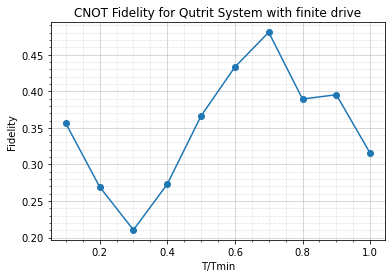

In [8]:
df = pd.read_csv("RS_CNOT_QB.csv",names=["fidelity","time"])
plt.plot(df["time"],df["fidelity"],'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("CNOT Fidelity for Qutrit System with finite drive")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()

## Random Seed Graph Generation

Random Seed output's are in the 'RS_Fidelities' folder, with the corresponding wieghts in 'RandomSeed_Data'

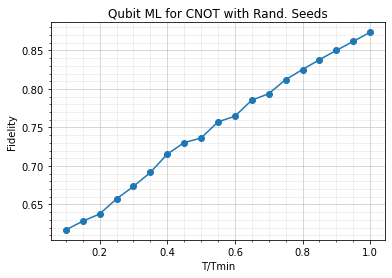

In [141]:
CNOT_QB_DF = pd.read_csv("RS_Fidelities/RS_CNOT_QB.csv",names=["fidelity","time"])
foo_DF = CNOT_QB_DF.sort_values(by="time")
foo_DF = foo_DF.reset_index().drop('index',axis=1).drop(index=[0])
fname = "CNOT_RS"
plt.plot(foo_DF["time"],foo_DF["fidelity"],'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("Qubit ML for CNOT with Rand. Seeds")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()
plt.savefig(os.path.join(os.getcwd(),"Figures",fname+".pdf"), format="pdf")

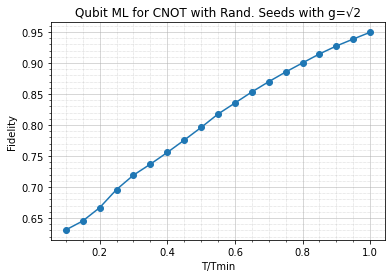

In [142]:
CNOT_QB_gR2_DF = pd.read_csv("RS_Fidelities/RS_CNOT_QB_gR2.csv",names=["fidelity","time"])
foo_DF2 = CNOT_QB_gR2_DF.sort_values(by="time")
foo_DF2 = foo_DF2.reset_index().drop('index',axis=1).drop(index=[0])
fname = "CNOT_RS_gR2"
plt.plot(foo_DF2["time"],foo_DF2["fidelity"],'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("Qubit ML for CNOT with Rand. Seeds with g=\u221A2")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()
plt.savefig(os.path.join(os.getcwd(),"Figures",fname+".pdf"), format="pdf")

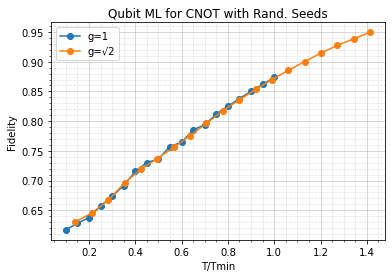

In [143]:
fname = "CNOT_RS_gBoth"
plt.plot(foo_DF["time"],foo_DF["fidelity"],'o-')
plt.plot(foo_DF2["time"] * np.sqrt(2),foo_DF2["fidelity"],'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("Qubit ML for CNOT with Rand. Seeds")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.legend(["g=1","g=\u221A2"])
plt.minorticks_on()
plt.savefig(os.path.join(os.getcwd(),"Figures",fname+".pdf"), format="pdf")

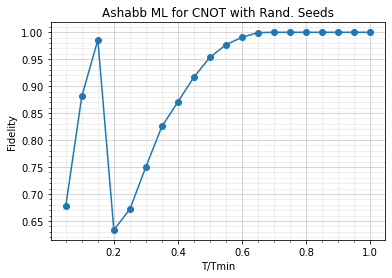

In [180]:
CNOT_A = pd.read_csv("RS_Fidelities/RS_CNOT_A.csv",names=["fidelity","time"])
DFA = CNOT_A.sort_values(by="time")
DFA = DFA.reset_index().drop('index',axis=1).drop(index=[])
fname = "CNOT_A"
plt.plot(DFA["time"],DFA["fidelity"],'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("Ashabb ML for CNOT with Rand. Seeds")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()
plt.savefig(os.path.join(os.getcwd(),"Figures",fname+".pdf"), format="pdf")

In [181]:
CNOT_A

,fidelity,time
0,0.633314,0.20
1,0.671757,0.25
2,0.985722,0.15
3,0.881144,0.10
4,0.750400,0.30
5,0.825305,0.35
6,0.870925,0.40
7,0.999321,0.65
8,0.976907,0.55
9,0.953554,0.50


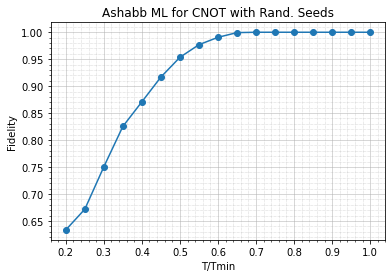

In [146]:
CNOT_A = pd.read_csv("RS_Fidelities/RS_CNOT_A.csv",names=["fidelity","time"])
DFA = CNOT_A.sort_values(by="time")
DFA = DFA.reset_index().drop('index',axis=1).drop(index=[0,1,2])
fname = "CNOT_A"
plt.plot(DFA["time"],DFA["fidelity"],'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("Ashabb ML for CNOT with Rand. Seeds")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()
plt.savefig(os.path.join(os.getcwd(),"Figures",fname+".pdf"), format="pdf")

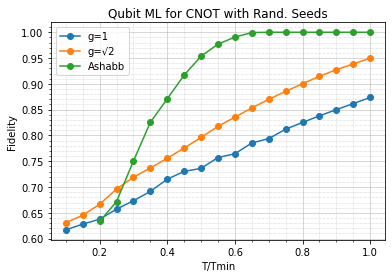

In [147]:
fname = "CNOT_RS_gAll"
plt.plot(foo_DF["time"],foo_DF["fidelity"],'o-')
plt.plot(foo_DF2["time"],foo_DF2["fidelity"],'o-')
plt.plot(DFA["time"],DFA["fidelity"],'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("Qubit ML for CNOT with Rand. Seeds")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.legend(["g=1","g=\u221A2","Ashabb"])
plt.minorticks_on()
plt.savefig(os.path.join(os.getcwd(),"Figures",fname+".pdf"), format="pdf")

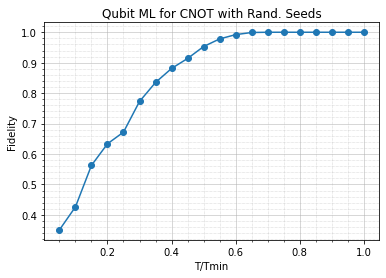

In [158]:
CNOT_Protocol = pd.read_csv("RS_Fidelities/RS_CNOT_ZXP.csv",names=["fidelity","time"])
foo_DF3 = CNOT_Protocol.sort_values(by="time")
foo_DF3 = foo_DF3.reset_index().drop('index',axis=1)
fname = "CNOT_RS_Protocol"
plt.plot(foo_DF3["time"],foo_DF3["fidelity"],'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("Qubit ML for CNOT with Rand. Seeds")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()
plt.savefig(os.path.join(os.getcwd(),"Figures",fname+".pdf"), format="pdf")

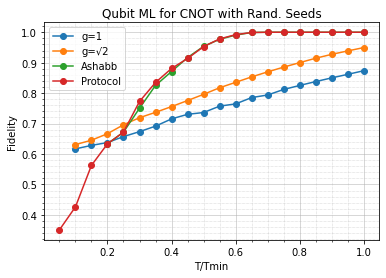

In [159]:
fname = "CNOT_RS_gAllCNOT"
plt.plot(foo_DF["time"],foo_DF["fidelity"],'o-')
plt.plot(foo_DF2["time"],foo_DF2["fidelity"],'o-')
plt.plot(DFA["time"],DFA["fidelity"],'o-')
plt.plot(foo_DF3["time"],foo_DF3["fidelity"],'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("Qubit ML for CNOT with Rand. Seeds")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.legend(["g=1","g=\u221A2","Ashabb","Protocol"])
plt.minorticks_on()
plt.savefig(os.path.join(os.getcwd(),"Figures",fname+".pdf"), format="pdf")

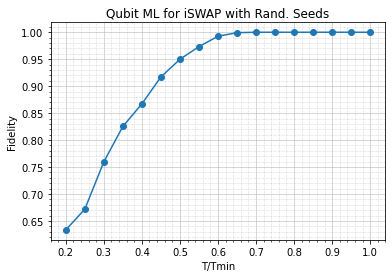

In [151]:
iSWAP = pd.read_csv("RS_Fidelities/RS_iSWAP_QB.csv",names=["fidelity","time"])
foo_DF4 = iSWAP.sort_values(by="time")
foo_DF4 = foo_DF4.reset_index().drop('index',axis=1).drop(index=[0,1,2])
fname = "CNOT_RS_Protocol"
plt.plot(foo_DF4["time"],foo_DF4["fidelity"],'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("Qubit ML for iSWAP with Rand. Seeds")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()
#plt.savefig(os.path.join(os.getcwd(),"Figures",fname+".pdf"), format="pdf")

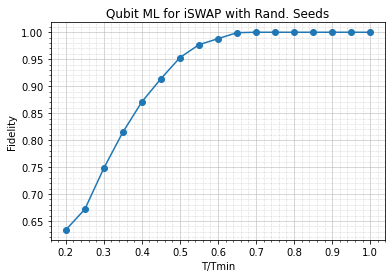

In [153]:
iSWAP_QT = pd.read_csv("RS_Fidelities/RS_iSWAP_ZXP.csv",names=["fidelity","time"])
foo_DF5 = iSWAP_QT.sort_values(by="time")
foo_DF5 = foo_DF5.reset_index().drop('index',axis=1).drop(index=[0,1,2])
fname = "CNOT_RS_Protocol"
plt.plot(foo_DF5["time"],foo_DF5["fidelity"],'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("Qubit ML for iSWAP with Rand. Seeds")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()

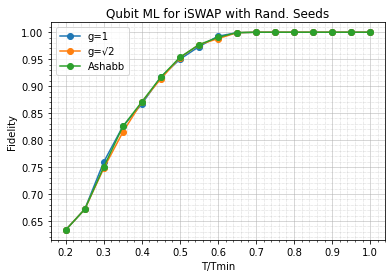

In [154]:
fname = "CNOT_RS_gAllCNOT"
plt.plot(foo_DF4["time"],foo_DF4["fidelity"],'o-')
plt.plot(foo_DF5["time"],foo_DF5["fidelity"],'o-')
plt.plot(DFA["time"],DFA["fidelity"],'o-')
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("Qubit ML for iSWAP with Rand. Seeds")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.legend(["g=1","g=\u221A2","Ashabb","Protocol"])
plt.minorticks_on()
plt.savefig(os.path.join(os.getcwd(),"Figures",fname+".pdf"), format="pdf")

In [160]:
CNOT_A = pd.read_csv("RS_Fidelities/RS_CNOT_A.csv",names=["fidelity","time"])
DFA = CNOT_A.sort_values(by="time")
DFA

,fidelity,time
19,0.677722,0.05
3,0.881144,0.10
2,0.985722,0.15
0,0.633314,0.20
1,0.671757,0.25
4,0.750400,0.30
5,0.825305,0.35
6,0.870925,0.40
14,0.916879,0.45
9,0.953554,0.50


We observe that we nearly saturate the speed limit at nearly t=0.15*tmin. 

In [166]:
W = np.loadtxt("RandomSeed_Data/RS_CNOT_A_all/Weights/RS_CNOT_A_Wt0.15.csv",delimiter=",")

In [168]:
np.shape(Weights)

(16, 8)

So we have 16 pulses but 8 pulse parameters each which represent the X,Y drives for each energy transition (0<->1 and 1<->2) for each qutrit which is $2*2*2 = 8.$ Evolving this Hamiltonian with time to see if it hits our target unitary, we have 

In [194]:
#Coupling Strength 
g = 1 

#Drives (need X & Y because optimizer does not generate complex numbers)
sx = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
sy = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
sxx = np.array([[0,0,0],[0,0,1],[0,1,0]]) 
syy = np.array([[0,0,0],[0,0,-1j],[0,1j,0]]) 
id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) #Note that this identity has all entries but the drives do not. 

# Annhilation and Creation Operators for Qutrit System with Higher Energy Coupling 
annhilate = np.array([[0,1,0],[0,0,np.sqrt(2)],[0,0,0]])
create = annhilate.T
H0 = torch.tensor(g*np.kron(annhilate + create,annhilate + create))


#Sums Pauli gates with coefficients (helper function)
def sum_pauli(coef, gate):
    total_pauli =  torch.tensor(np.zeros([3 ** N, 3 ** N]))
    for i in range(0,N):
        pauli_temp = 1
        for j in range(0,i):
            pauli_temp = torch.tensor(np.kron(pauli_temp,id))
        pauli_temp = torch.tensor(np.kron(pauli_temp,gate))
        for j in range(i+1,N):
            pauli_temp = torch.tensor(np.kron(pauli_temp,id))
        total_pauli = total_pauli + coef[i]*pauli_temp
    return total_pauli

N = 2
dt = torch.cdouble
U_Exp = 1
M = 16
W = np.loadtxt("RandomSeed_Data/RS_CNOT_A_all/Weights/RS_CNOT_A_Wt0.15.csv",delimiter=",")
print(np.shape(W))
t = 0.15 * np.pi/4
for i in range(0,N):
    U_Exp = torch.tensor(np.kron(U_Exp,id),dtype=dt)#initializing unitary
for m in range(0,M):#Product of pulses
    pulse_coef = W[m]
    H1 = sum_pauli(pulse_coef[:N],sx) + sum_pauli(pulse_coef[N:2*N],sy) + sum_pauli(pulse_coef[2*N:3*N],sxx) + sum_pauli(pulse_coef[3*N:4*N],syy) 
    U_Exp = torch.matmul(torch.matrix_exp(-1j*(H0+H1)*t/M),U_Exp)

SU = []
CNOT = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
pauli_int = [1,2,3,4]
perms = list(product(pauli_int,repeat=N))#all permutations of paulis
#Paul Matrices only in the qubit space 
sxq = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
syq = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
szq = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) 
idq = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 0]]) 
for p in perms:#mapping integers to pauli 
    unitary = 1
    for pauli in p:
        if pauli == 1: unitary = torch.tensor(np.kron(unitary,sxq),dtype=torch.cdouble)
        elif pauli == 2: unitary = torch.tensor(np.kron(unitary,syq),dtype=torch.cdouble)
        elif pauli == 3: unitary = torch.tensor(np.kron(unitary,szq),dtype=torch.cdouble)
        elif pauli == 4: unitary = torch.tensor(np.kron(unitary,idq),dtype=torch.cdouble)
    SU.append(unitary)
fidelity = 0
d = 2**N

for U in SU:
    eps_U = torch.matmul(torch.matmul(U_Exp,U),(U_Exp.conj().T))
    target_U = torch.matmul(torch.matmul(CNOT,(U.conj().T)),(CNOT.conj().T))
    tr = torch.trace(torch.matmul(target_U,eps_U))
    fidelity = fidelity + tr 
infidelity = 1 - abs(fidelity + d*d)/(d*d*(d+1))
print(infidelity)

(16, 8)
tensor(0.6778, dtype=torch.float64)


## Random Seed Data Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

All Data is stored in the RS_Outputs Folder under the Data folder. 

### CNOT Qubit Analysis 

Here is an analysis of the output of Wendian's code. Here I will graph the gates CNOT, iSWAP, and SWAP with 5 different ML protocols. 

In [63]:
def genPlot(fname,df,l):
    plt.plot(df["time"],df["fidelity"],'o-')
    plt.xlabel("T/Tmin")
    plt.ylabel("Fidelity")
    plt.title(fname)
    plt.grid(which='major', linestyle='-', linewidth='0.5')
    plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
    plt.minorticks_on()
    plt.legend(l)

Here is the graph of CNOT in the qubit space with a standard coupling strength.

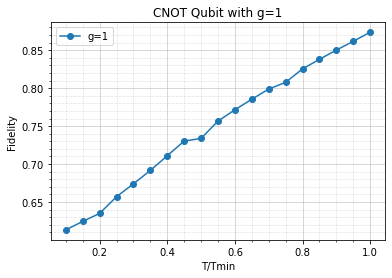

In [64]:
CNOT_QB_DF = pd.read_csv("RandomSeed_Output/CNOT/CNOT_Qubit.csv",names=["fidelity","time"])
CNOT_QB_DF.sort_values(by="time",inplace=True)
CNOT_QB_DF = CNOT_QB_DF.reset_index().drop('index',axis=1).drop(index=[0])
genPlot("CNOT Qubit with g=1",CNOT_QB_DF,["g=1"])

Here is the graph of CNOT with the coupling strength as $g=\sqrt{2}$.

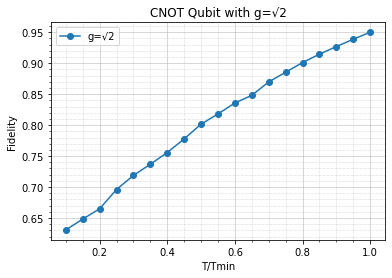

In [65]:
CNOT_QB2_DF = pd.read_csv("RandomSeed_Output/CNOT/CNOT_Qubit_gRoot2.csv",names=["fidelity","time"])
CNOT_QB2_DF.sort_values(by="time",inplace=True)
CNOT_QB2_DF = CNOT_QB2_DF.reset_index().drop('index',axis=1).drop(index=[0])
genPlot("CNOT Qubit with g=\u221A2",CNOT_QB2_DF,["g=\u221A2"])

Combinding the two, we have 

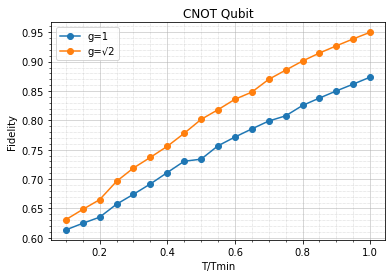

In [66]:
genPlot("CNOT Qubit with g=1",CNOT_QB_DF,["foo"])
genPlot("CNOT Qubit",CNOT_QB2_DF,["g=1","g=\u221A2"])

Checking this graph for correctness, we have

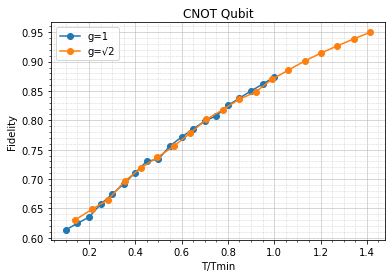

In [67]:
temp_df = CNOT_QB2_DF.copy(deep=True)
temp_df["time"] = np.sqrt(2) * temp_df["time"]
genPlot("CNOT Qubit with g=1",CNOT_QB_DF,["foo"])
genPlot("CNOT Qubit",temp_df,["g=1","g=\u221A2"])

Great now we have confidence in our code. Now looking at our more exotic protocols, we will graph the Ashabb Coupling Hamiltonian in qutrit space

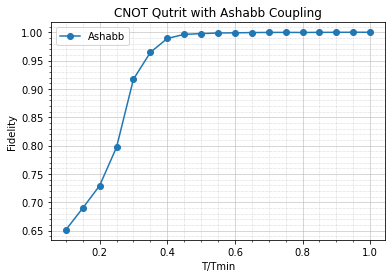

In [52]:
CNOT_A_DF = pd.read_csv("RandomSeed_Output/CNOT/CNOT_Ashabb.csv",names=["fidelity","time"])
CNOT_A_DF.sort_values(by="time",inplace=True)
CNOT_A_DF = CNOT_A_DF.reset_index().drop('index',axis=1).drop(index=[0])
genPlot("CNOT Qutrit with Ashabb Coupling",CNOT_A_DF,["Ashabb"])

Plotting this with the previous protocols, we have

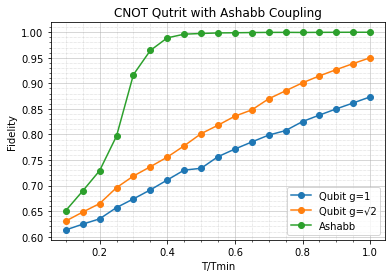

In [53]:
genPlot("CNOT Qubit with g=1",CNOT_QB_DF,["foo"])
genPlot("CNOT Qubit",CNOT_QB2_DF,["foo"])
genPlot("CNOT Qutrit with Ashabb Coupling",CNOT_A_DF,["Qubit g=1","Qubit g=\u221A2","Ashabb"])

This is the expected behavior studied for the Ashabb Hamtilonian. Now let us look at the protocol proposed by Dr. Zhexuan Gong. This protocol is similar to the bosonic protocol of swapping a particle with a speed up using a novel system with engtanglement and superpostion. Now there are two variants of this protocol, one with qubit and qutrit drives and the other with just qutrit drives. We will denote these as ZXG_sub (for just the qutrit drives) and ZXG_full (for both qubit and qutrit drives). Now looking at ZXG_sub, we have 

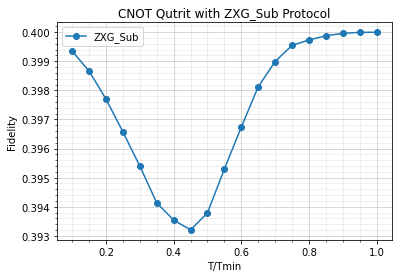

In [54]:
CNOT_ZXGSUB_DF = pd.read_csv("RandomSeed_Output/CNOT/CNOT_ZXG_Protocol_Sub.csv",names=["fidelity","time"])
CNOT_ZXGSUB_DF.sort_values(by="time",inplace=True)
CNOT_ZXGSUB_DF = CNOT_ZXGSUB_DF.reset_index().drop('index',axis=1).drop(index=[0])
genPlot("CNOT Qutrit with ZXG_Sub Protocol",CNOT_ZXGSUB_DF,["ZXG_Sub"])

Plotting this with the previous graphs, we have 

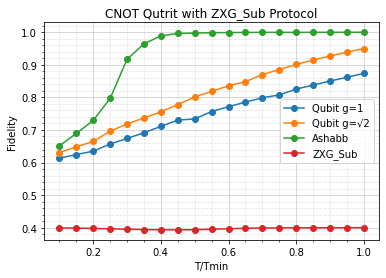

In [55]:
genPlot("CNOT Qubit with g=1",CNOT_QB_DF,["foo"])
genPlot("CNOT Qubit",CNOT_QB2_DF,["foo"])
genPlot("CNOT Qutrit with Ashabb Coupling",CNOT_A_DF,["foo"])
genPlot("CNOT Qutrit with ZXG_Sub Protocol",CNOT_ZXGSUB_DF,["Qubit g=1","Qubit g=\u221A2","Ashabb","ZXG_Sub"])

This is unforunately which poor performance. Lets now look at the ZXG Protocl with both qubit and qutrit drives. 

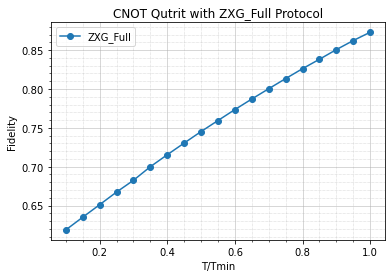

In [57]:
CNOT_ZXGFULL_DF = pd.read_csv("RandomSeed_Output/CNOT/CNOT_ZXG_Protocol_Full.csv",names=["fidelity","time"])
CNOT_ZXGFULL_DF.sort_values(by="time",inplace=True)
CNOT_ZXGFULL_DF = CNOT_ZXGFULL_DF.reset_index().drop('index',axis=1).drop(index=[0])
genPlot("CNOT Qutrit with ZXG_Full Protocol",CNOT_ZXGFULL_DF,["ZXG_Full"])

Unforunately this look like the standard $g=1$ coupling for the qubit system. Graphing everything together we have

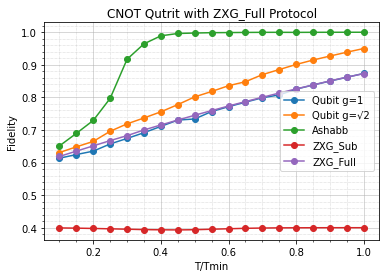

In [58]:
genPlot("CNOT Qubit with g=1",CNOT_QB_DF,["foo"])
genPlot("CNOT Qubit",CNOT_QB2_DF,["foo"])
genPlot("CNOT Qutrit with Ashabb Coupling",CNOT_A_DF,["foo"])
genPlot("CNOT Qutrit with ZXG_Sub Protocol",CNOT_ZXGSUB_DF,["foo"])
genPlot("CNOT Qutrit with ZXG_Full Protocol",CNOT_ZXGFULL_DF,["Qubit g=1","Qubit g=\u221A2","Ashabb","ZXG_Sub","ZXG_Full"])

This is unforunate results as we do not see any speed up with the new protocol. Repeating this analysis for the SWAP and iSWAP gates, we have

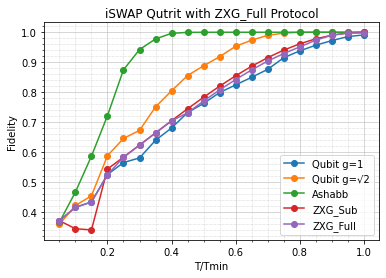

In [69]:
iSWAP_QB_DF = pd.read_csv("RandomSeed_Output/iSWAP/iSWAP_Qubit.csv",names=["fidelity","time"])
iSWAP_QB2_DF = pd.read_csv("RandomSeed_Output/iSWAP/iSWAP_Qubit_gRoot2.csv",names=["fidelity","time"])
iSWAP_A_DF = pd.read_csv("RandomSeed_Output/iSWAP/iSWAP_Ashabb.csv",names=["fidelity","time"])
iSWAP_ZXGSUB_DF = pd.read_csv("RandomSeed_Output/iSWAP/iSWAP_ZXG_Protocol_Sub.csv",names=["fidelity","time"])
iSWAP_ZXGFULL_DF = pd.read_csv("RandomSeed_Output/iSWAP/iSWAP_ZXG_Protocol_Full.csv",names=["fidelity","time"])

iSWAP_QB_DF.sort_values(by="time",inplace=True)
iSWAP_QB2_DF.sort_values(by="time",inplace=True)
iSWAP_A_DF.sort_values(by="time",inplace=True)
iSWAP_ZXGSUB_DF.sort_values(by="time",inplace=True)
iSWAP_ZXGFULL_DF.sort_values(by="time",inplace=True)

genPlot("iSWAP Qubit with g=1",iSWAP_QB_DF,["foo"])
genPlot("iSWAP Qubit",iSWAP_QB2_DF,["foo"])
genPlot("iSWAP Qutrit with Ashabb Coupling",iSWAP_A_DF,["foo"])
genPlot("iSWAP Qutrit with ZXG_Sub Protocol",iSWAP_ZXGSUB_DF,["foo"])
genPlot("iSWAP Qutrit with ZXG_Full Protocol",iSWAP_ZXGFULL_DF,["Qubit g=1","Qubit g=\u221A2","Ashabb","ZXG_Sub","ZXG_Full"])

We observe similiar bevhaior for the $iSWAP$ gate compared to the $CNOT$ gate, where there is no visible speed-up from the ZXG Protocol. Note there are small non-smooth behavior, but this would likely go away if we averaged over more seeds. But doing the same analysis for $SWAP$, we see

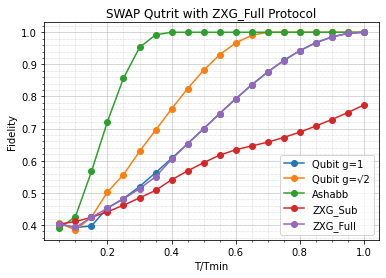

In [70]:
SWAP_QB_DF = pd.read_csv("RandomSeed_Output/SWAP/SWAP_Qubit.csv",names=["fidelity","time"])
SWAP_QB2_DF = pd.read_csv("RandomSeed_Output/SWAP/SWAP_Qubit_gRoot2.csv",names=["fidelity","time"])
SWAP_A_DF = pd.read_csv("RandomSeed_Output/SWAP/SWAP_Ashabb.csv",names=["fidelity","time"])
SWAP_ZXGSUB_DF = pd.read_csv("RandomSeed_Output/SWAP/SWAP_ZXG_Protocol_Sub.csv",names=["fidelity","time"])
SWAP_ZXGFULL_DF = pd.read_csv("RandomSeed_Output/SWAP/SWAP_ZXG_Protocol_Full.csv",names=["fidelity","time"])

SWAP_QB_DF.sort_values(by="time",inplace=True)
SWAP_QB2_DF.sort_values(by="time",inplace=True)
SWAP_A_DF.sort_values(by="time",inplace=True)
SWAP_ZXGSUB_DF.sort_values(by="time",inplace=True)
SWAP_ZXGFULL_DF.sort_values(by="time",inplace=True)

genPlot("SWAP Qubit with g=1",SWAP_QB_DF,["foo"])
genPlot("SWAP Qubit",SWAP_QB2_DF,["foo"])
genPlot("SWAP Qutrit with Ashabb Coupling",SWAP_A_DF,["foo"])
genPlot("SWAP Qutrit with ZXG_Sub Protocol",SWAP_ZXGSUB_DF,["foo"])
genPlot("SWAP Qutrit with ZXG_Full Protocol",SWAP_ZXGFULL_DF,["Qubit g=1","Qubit g=\u221A2","Ashabb","ZXG_Sub","ZXG_Full"])

We see the similar speed up behavior to the other gates, as there is no signifcant speed-up. This is quite unforunate.

## Separate Protocol Testing

Now this is for the number operator coupling testing

In [3]:
n2 = np.array([[0,0],[0,1]]) #qubit number operator
print(n2)

[[0 0]
 [0 1]]


In [5]:
n3 = np.array([[0,0,0],[0,1,0],[0,0,2]]) #qubit number operator
print(n3)

[[0 0 0]
 [0 1 0]
 [0 0 2]]


The coupling Matrices for qubit and qutrit are 

In [7]:
np.kron(n2,n2)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1]])

and

In [6]:
np.kron(n3,n3)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 4]])

This matches up with the Mathematica, so we are confident in our coupling matix 

In [1]:
from nop_QBML import fidelity_ml
fidelity_ml(1,1,1,1,1,1)

nop_QBML
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]]


TypeError: unsupported operand type(s) for +: 'numpy.ndarray' and 'Tensor'

In [20]:
from nop_QTML import fidelity_ml
fidelity_ml(1,1,1,1,1,1)

nop_qutrit
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 4]]


TypeError: unsupported operand type(s) for +: 'numpy.ndarray' and 'Tensor'

While we are getting errors, this is due to incorrect input. We do see our coupling matrices are correct in our files. Now we will update our workflow, and then we should be able to run our code. 

Now we will compare the Ashabb Hamiltonian to the qubit ML with the correct coupling Hamiltonian ($XX$ instead of the flip-flop). 

In [2]:
sx = np.array([[0, 1], [1, 0]])
np.kron(sx,sx)

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

In [4]:
#Coupling terms in Hamiltonian 
n3 = np.array([[0,0,0],[0,1,0],[0,0,1]]) #qubit number operator
H0 = torch.tensor(np.kron(n3,n3))
print(H0)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]])


## Development of State Transfer Protocol 

In [57]:
from numpy import array,zeros,kron
from torch import matmul,matrix_exp,tensor
import torch
from itertools import product
import numpy as np
def stateTransfer_ml(M,t,N_iter,rseed):
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Aug 16 4:33 2021

    @author: Bora & Alex

    This is the original code for Joel's Paper.

    Note that we have XX coupling in this script at the moment
    """
    
    #Pauli Matricies
    sx = array([[0, 1], [1, 0]])
    sy = array([[0,-1j],[1j,0]])
    id = array([[1,0],[0,1]])
    
    def sum_pauli(coef, gate):#Sums Pauli gates with coefficients 
        N = len(coef)#number of qubits
        total_pauli = tensor(zeros([2 ** N,2 ** N]))
        for i in range(0,N):
            pauli_temp = 1
            for j in range(0,i):
                pauli_temp = tensor(kron(pauli_temp,id))
            pauli_temp = tensor(kron(pauli_temp,gate))
            for j in range(i+1,N):
                pauli_temp = tensor(kron(pauli_temp,id))
            total_pauli = total_pauli + coef[i]*pauli_temp
        return total_pauli

    #variable initializations
    N = 2
    torch.manual_seed(rseed) 
    dt = torch.cdouble
    infidelity_list=torch.zeros([N_iter,1])

    #H0 generation
    n2 = np.array([[0,0],[0,1]]) #qubit number operator
    H0 = torch.tensor(np.kron(n2,n2))

    #Optimization Coefficents 
    R = torch.rand([M,2*N], dtype=torch.double) *2*np.pi 
    R.requires_grad = True 

    #Optimizer settings(can be changed & optimized)
    optimizer = torch.optim.SGD([R], lr = 0.3, momentum=0.99, nesterov=True)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.03, factor=0.3 , patience= 20)

    for n in range(0,N_iter):
        #Creating Hamilontian
        U_Exp = 1
        for i in range(0,N):
            U_Exp = tensor(kron(U_Exp,id),dtype=dt)#initializing unitary
        for m in range(0,M):#Product of pulses
            pulse_coef = R[m]
            H1 = sum_pauli(pulse_coef[:N],sx) + sum_pauli(pulse_coef[N:],sy)
            U_Exp = matmul(matrix_exp(-1j*(H0+H1)*t/M),U_Exp)

        #Fidelity calulcation given by Nielsen Paper
        zero_state = np.array([1,0])
        one_state = np.array([0,1])
        OO_state = np.kron(zero_state,zero_state)
        ll_state = np.kron(one_state,one_state)
        initial_state = tensor(OO_state,dtype=dt)
        target_state = tensor(1/np.sqrt(2) * (OO_state + ll_state),dtype=dt)

        fidelity = abs(torch.dot(U_Exp @ initial_state,target_state)) ** 2

        

        infidelity = 1 - fidelity
        infidelity_list[n] = infidelity.detach()
        infidelity.backward()

        #Printing statement
        #if (n+1)%100==0: print('Itertation ', str(n+1), ' out of ', str(N_iter), 'complete. Avg Infidelity: ', str(infidelity.item()))

        #optimizer 
        optimizer.step()
        scheduler.step(infidelity)
        optimizer.zero_grad()

        if fidelity - 0.9999 > 0: #Stopping condition for high fidelity iterations
            return [1 - infidelity_list.min().item(),R.detach().numpy()]
    
    return [1-infidelity_list.min().item(),R.detach().numpy()]

In [ ]:
[fidelity,Weights] =  stateTransfer_ml(16,np.pi,5000,8)
print("Final Fidelity is: " + str(fidelity))

In [7]:
import numpy as np
zero_state = np.array([1,0])
one_state = np.array([0,1])
OO_state = np.kron(zero_state,zero_state)
ll_state = np.kron(one_state,one_state)
initial_state = OO_state
target_state = 1/np.sqrt(2) * (OO_state + ll_state)
print(OO_state)
print(ll_state)
print(initial_state)
print(target_state)

[1 0 0 0]
[0 0 0 1]
[1 0 0 0]
[0.70710678 0.         0.         0.70710678]


In [23]:
import torch
from torch import tensor
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0,-1j],[1j,0]])
id = np.array([[1,0],[0,1]])
torch.tensor(np.kron(id,id)) @ torch.tensor(OO_state)

tensor([1, 0, 0, 0])

In [30]:
from torch import tensor
dt = torch.cdouble
zero_state = np.array([1,0])
one_state = np.array([0,1])
OO_state = np.kron(zero_state,zero_state)
ll_state = np.kron(one_state,one_state)
initial_state = tensor(OO_state,dtype=dt)
target_state = tensor(1/np.sqrt(2) * (OO_state + ll_state),dtype=dt)

#U_Exp = tensor(np.kron(id,id),dtype=dt)

fidelity = abs(torch.dot(U_Exp @ initial_state,target_state)) ** 2
print(fidelity)

tensor(0.5000, dtype=torch.float64)


In [60]:
#Imports are here too to export block to Wendian script
import torch
import numpy as np
from itertools import product

def stateTransfer_ml(M,t,N_iter,rseed):
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Aug 16 4:33 2021

    @author: Bora & Alex


    DESC: This function deos the state transfer protocol for a qutrit system. 
    """


    #Pauli Matricies in Qutrit Space
    sx = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
    sy = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
    sxx = np.array([[0,0,0],[0,0,1],[0,1,0]]) 
    syy = np.array([[0,0,0],[0,0,-1j],[0,1j,0]]) 
    id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) 

    
    #Function definitions 
    
    def sum_pauli(coef, gate):#Sums Pauli gates with coefficients 
        total_pauli = torch.tensor(np.zeros([3 ** N, 3 ** N]))
        for i in range(0,N):
            pauli_temp = 1
            for j in range(0,i):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            pauli_temp = torch.tensor(np.kron(pauli_temp,gate))
            for j in range(i+1,N):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            #total_pauli = total_pauli + maxFreq*torch.cos(coef[i])*pauli_temp
            total_pauli = total_pauli + coef[i]*pauli_temp
        return total_pauli

    #variable initializations
    N = 2
    torch.manual_seed(rseed)
    dt = torch.cdouble # datatype and precision
    infidelity_list=torch.zeros([N_iter,1])

    #Coupling terms in Hamiltonian 
    n3 = np.array([[0,0,0],[0,1,0],[0,0,2]]) #qubit number operator
    H0 = torch.tensor(np.kron(n3,n3))

    #These are the coefficients we are optimizing
    R = torch.rand([M,4*N], dtype=torch.double) *2*np.pi # Random initialization (between 0 and 2pi)
    R.requires_grad = True # set flag so we can backpropagate

    optimizer = torch.optim.SGD([R], lr = 0.3, momentum=0.99, nesterov=True)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.03, factor=0.3 , patience= 20 )

    #prev_infidelity = -1
    for n in range(0,N_iter):
        #Creating Drive Hamilontian
        U_Exp = 1
        for i in range(0,N):
            U_Exp = torch.tensor(np.kron(U_Exp,id),dtype=dt)#initializing unitary
        for m in range(0,M):#Product of pulses
            pulse_coef = R[m]
            H1 = sum_pauli(pulse_coef[:N],sx) + sum_pauli(pulse_coef[N:2*N],sy) + sum_pauli(pulse_coef[2*N:3*N],sxx) + sum_pauli(pulse_coef[3*N:4*N],syy) 
            U_Exp = torch.matmul(torch.matrix_exp(-1j*(H0+H1)*t/M),U_Exp)

        #Fidelity calulcation given by Nielsen Paper
        zero_state = np.array([1,0,0])
        one_state = np.array([0,1,0])
        OO_state = np.kron(zero_state,zero_state)
        ll_state = np.kron(one_state,one_state)
        initial_state = tensor(OO_state,dtype=dt)
        target_state = tensor(1/np.sqrt(2) * (OO_state + ll_state),dtype=dt)

        fidelity = abs(torch.dot(U_Exp @ initial_state,target_state)) ** 2
        
        infidelity = 1 - fidelity
        infidelity_list[n] = infidelity.detach()
        infidelity.backward()

        #Printing statement
        #if (n+1)%100==0: print('Itertation ', str(n+1), ' out of ', str(N_iter), 'complete. Avg Infidelity: ', str(infidelity.item()))

        #optimizer 
        optimizer.step()
        scheduler.step(infidelity)
        optimizer.zero_grad()

        if fidelity - 0.9999 > 0: #Stopping condition for high fidelity iterations
            return [1 - infidelity_list.min().item(),R.detach().numpy()]

    return [1 - infidelity_list.min().item(),R.detach().numpy()]

In [61]:
[fidelity,Weights] =  stateTransfer_ml(16,np.pi,5000,8)
print("Final Fidelity is: " + str(fidelity))

Final Fidelity is: 1.0


In [50]:
from torch import tensor
dt = torch.cdouble
zero_state = np.array([1,0,0])
one_state = np.array([0,1,0])
two_state = np.array([0,0,1])
OO_state = np.kron(zero_state,zero_state)
print(OO_state)
ll_state = np.kron(one_state,one_state)
print(ll_state)
initial_state = tensor(OO_state,dtype=dt)
target_state = tensor(1/np.sqrt(2) * (OO_state + ll_state),dtype=dt)
print(target_state)

#id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) 
#U_Exp = tensor(np.kron(id,id),dtype=dt)

fidelity = abs(torch.dot(U_Exp @ initial_state,target_state)) ** 2
print(fidelity)

[1 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0]
tensor([0.7071+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.7071+0.j, 0.0000+0.j, 0.0000+0.j,
        0.0000+0.j, 0.0000+0.j], dtype=torch.complex128)
tensor(0.5000, dtype=torch.float64)


In [63]:
print("'test'")

'test'


In [8]:
import numpy as np 
H = np.zeros([3 ** 2, 3 ** 2])
H[1,3] = 1
H[2,3] = 1
print(H + H.transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [5]:
def qubitSubspace(gate):
    gate = np.delete(gate,2,0)
    gate = np.delete(gate,2,1)
    return gate[:4,:4]

In [10]:
H0 = H + H.transpose()
qubitSubspace(H0)

array([[0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.]])

In [6]:
import numpy as np 
import torch
from Full_ML import fidelity_ml
def qubitSubspace(gate):
    gate = np.delete(gate,2,0)
    gate = np.delete(gate,2,1)
    return gate[:4,:4]
H = np.zeros([3 ** 2, 3 ** 2])
H[1,3] = 1
H[2,3] = 1
H0 = H + H.transpose()
from Full_ML import fidelity_ml
dt = torch.cdouble

#iSWAP = torch.tensor([[1,0,0,0],[0,0,1j,0],[0,1j,0,0],[0,0,0,1]],dtype=dt)
iSWAP = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,0,0,1j,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,1j,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=dt)
#fidelity_ml(3,iSWAP,np.pi,500,8,torch.tensor(qubitSubspace(H0)),2)
fidelity_ml(3,iSWAP,np.pi,500,8,torch.tensor(H0),3,0)

Itertation  100  out of  500 complete. Avg Infidelity:  0.3273494611262654
Itertation  200  out of  500 complete. Avg Infidelity:  0.2540340003176125
Itertation  300  out of  500 complete. Avg Infidelity:  0.24252722898216572
Itertation  400  out of  500 complete. Avg Infidelity:  0.2338239500032312
Itertation  500  out of  500 complete. Avg Infidelity:  0.2306289237935275
[array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 0]]), array([[ 0.+0.j, -0.-1.j,  0.+0.j],
       [ 0.+1.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j]]), array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]), array([[ 0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -0.-1.j],
       [ 0.+0.j,  0.+1.j,  0.+0.j]])]


[0.7693710774183273,
 array([[ 7.17741598,  4.30839339, -0.28892874,  1.77803078,  0.04886441,
          0.9459662 ,  0.10834953, -2.02840975],
        [ 1.47292763,  5.52851794,  4.4631117 ,  1.78267887, -0.03120109,
          5.07935785, -0.05745226,  7.0695892 ],
        [ 0.39068418,  0.11111345,  7.40177357, -0.0444563 , -0.17798997,
          3.86420818, -0.0869337 ,  6.03987265]])]

In [23]:
import torch
dt = torch.cdouble
iSWAP = torch.tensor([[1,0,0,0],[0,0,1j,0],[0,1j,0,0],[0,0,0,1]],dtype=dt)
print(np.shape(iSWAP.detach().numpy()) == (3,4))

False


In [8]:
from numpy import array
sx = array([[0, 1], [1, 0]])
sy = array([[0,-1j],[1j,0]])
sz = array([[1, 0], [0, -1]])
id = array([[1,0],[0,1]])

In [9]:
drives = [sx,sy,sz,id]

In [19]:
H1 = 0
for d in drives:
    H1 = H1 + torch.tensor(d)
print(H1)

tensor([[2.+0.j, 1.-1.j],
        [1.+1.j, 0.+0.j]], dtype=torch.complex128)


In [1]:
import numpy as np 
from numpy import array
sx = array([[0, 1], [1, 0]])
sy = array([[0,-1j],[1j,0]])
sz = array([[1, 0], [0, -1]])
id = array([[1,0],[0,1]])

In [7]:
drives = []
drives.append(sx);drives.append(sy)
print(type(len(drives[0])) ==int)
#Do drive error checking in control file 

True


In [10]:
 np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [1]:
from Full_ML import fidelity_ml
import numpy as np 
from numpy import array

In [3]:
sx = array([[0, 1], [1, 0]])
sy = array([[0,-1j],[1j,0]])
drives = [sx,sy]
input_gate = array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
H0 = np.kron(sx,sx)
fidelity_ml(3,input_gate,np.pi,500,8,H0,drives)

Drives
[[0 1]
 [1 0]]
[[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]]
Coupling matrix
tensor([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]], dtype=torch.complex128)
level2
Itertation  100  out of  500 complete. Avg Infidelity:  0.04726247396153149
Itertation  200  out of  500 complete. Avg Infidelity:  0.005645665997857541
Itertation  300  out of  500 complete. Avg Infidelity:  0.0038002411878241826
Itertation  400  out of  500 complete. Avg Infidelity:  0.002324260508756004
Itertation  500  out of  500 complete. Avg Infidelity:  0.00038915270360262433


[0.9996108472987544,
 array([[ 4.81331731e+00,  1.99215580e+00, -3.37580648e+00,
          2.71143491e-03],
        [ 4.01050799e+00,  1.57750915e+00,  3.34789343e+00,
          5.35766377e-03],
        [ 3.70101999e+00,  9.18017948e+00, -2.37125446e+00,
          5.44554663e-02]])]

In [4]:
sx = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
sy = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
sxx = np.array([[0,0,0],[0,0,1],[0,1,0]]) 
syy = np.array([[0,0,0],[0,0,-1j],[0,1j,0]]) 
drives = [sx,sy,sxx,syy]
input_gate = array([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]])
H0 = np.kron(sx,sx)
fidelity_ml(3,input_gate,np.pi,500,8,H0,drives)

Drives
[[0 1 0]
 [1 0 0]
 [0 0 0]]
[[ 0.+0.j -0.-1.j  0.+0.j]
 [ 0.+1.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j]]
[[0 0 0]
 [0 0 1]
 [0 1 0]]
[[ 0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -0.-1.j]
 [ 0.+0.j  0.+1.j  0.+0.j]]
Coupling matrix
tensor([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
       dtype=torch

[0.9095905050635338,
 array([[ 5.74568719,  5.84638475, -0.44250224,  0.22219064,  6.35053336,
         -0.45910612, -0.88754885,  1.10205625],
        [-0.11454719, -1.3695591 , -4.45137333, -0.17228031,  0.10311582,
          5.45659957,  0.10828524,  6.7430296 ],
        [ 5.89673404, -1.66935264, -0.01873247, -0.70699388,  0.98376015,
          8.23221102,  5.99498949,  3.6668982 ]])]

In [5]:
import numpy as np
H0 = np.zeros([3 ** 2, 3 ** 2])
for i in range(9):
    if i != 4: H0[i,4] = 1
H0 = H0 + H0.transpose()
print(H0)

[[0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [10]:
from numpy import array,kron
annhilate = array([[0,1,0],[0,0,np.sqrt(2)],[0,0,0]])
create = annhilate.T
H0 = kron(annhilate + create,annhilate + create)
for row in H0:
    print(row)
annhilate = array([[0,1,0],[0,0,1],[0,0,0]])
create = annhilate.T
H0 = kron(annhilate + create,annhilate + create)
print(H0)

[0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0.         0.         0.         1.         0.         1.41421356
 0.         0.         0.        ]
[0.         0.         0.         0.         1.41421356 0.
 0.         0.         0.        ]
[0.         1.         0.         0.         0.         0.
 0.         1.41421356 0.        ]
[1.         0.         1.41421356 0.         0.         0.
 1.41421356 0.         2.        ]
[0.         1.41421356 0.         0.         0.         0.
 0.         2.         0.        ]
[0.         0.         0.         0.         1.41421356 0.
 0.         0.         0.        ]
[0.         0.         0.         1.41421356 0.         2.
 0.         0.         0.        ]
[0. 0. 0. 0. 2. 0. 0. 0. 0.]
[[0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 1 0]
 [1 0 1 0 0 0 1 0 1]
 [0 1 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0]]


In [9]:
import torch

matrix = torch.zeros((3, 3))  # Example matrix with all zeros

if torch.all(matrix == 0):
    print("The matrix is all zeros.")
else:
    print("The matrix contains non-zero elements.")
torch.tensor(matrix)

The matrix is all zeros.


/Users/borabasyildiz/opt/anaconda3/envs/py7/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [19]:
dentries = torch.rand([1,5], dtype=torch.double) *2*np.pi
dentries.requires_grad = True
temp_vec = torch.tensor([0,0,1,0])
print(dentries)
H0 = np.zeros([3 ** 2, 3 ** 2])
H0 = torch.tensor(H0)
H0[2,2] = 1
for i in range(4):
    H0[3 ** 2 - i-1,3 ** 2 - i-1] = 1
print(H0)

tensor([[4.0962, 4.0787, 5.4298, 5.8248, 1.0362]], dtype=torch.float64)


RuntimeError: expand(torch.DoubleTensor{[5]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)

In [21]:
dentries = torch.rand([1,5], dtype=torch.double) *2*np.pi
dentries.requires_grad = True
temp_vec = torch.tensor([0,0,1,0])
torch.concat((temp_vec,dentries), dim=0)

RuntimeError: Tensors must have same number of dimensions: got 1 and 2

In [41]:
import numpy as np
dentries = torch.tensor(np.random.rand(5),dtype=torch.double)*2*np.pi
dentries.requires_grad = True
temp_vec = torch.tensor([0,0,1,0])

# Concatenate the vectors along the specified dimension (0 for rows, 1 for columns)
concatenated_vector = torch.cat((temp_vec, torch.cos(dentries)), dim=0)

print(concatenated_vector)
H0 = np.zeros([3 ** 2, 3 ** 2])
H0 = torch.tensor(H0)
H0[2,2] = 1
for i in range(5):
    H0[3 ** 2 - i-1,3 ** 2 - i-1] = 1
print(H0)
H0 = torch.mul(H0,concatenated_vector)
print(H0)

tensor([ 0.0000,  0.0000,  1.0000,  0.0000,  0.3085, -0.3543,  0.2145, -0.4842,
        -0.9689], dtype=torch.float64, grad_fn=<CatBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
         -0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
         -0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
         -0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
         -0.0000],
        [ 0.0000,  0.

## Ashhab Coupling Hamiltonian Analytics

In [21]:
import numpy as np 
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
def OpNorm(elevel):
    #Takes in Energy Levels and outputs operator norm of the normalized and non-normalized Ashabb Hamiltonian
    splus = np.zeros([elevel,elevel])
    splusn = np.zeros([elevel,elevel])
    for e in range(elevel-1):
        splus[e,e+1] = np.sqrt(e+1)
        splusn[e,e+1] = 1
    
    H = splus + np.transpose(splus)
    H = np.kron(H,H)
    normH = splusn + np.transpose(splusn)
    normH = np.kron(normH,normH)

    if elevel > 2:
        H = csr_matrix(H)
        normH = csr_matrix(normH)
        [evals,evecs] = eigs(H)
        [evalsn,evecsn] = eigs(normH)
        return [abs(max(evals,key=abs)),abs(max(evalsn,key=abs))]
    else: return [abs(max(np.linalg.eigvals(H),key=abs)),abs(max(np.linalg.eigvals(normH),key=abs))]


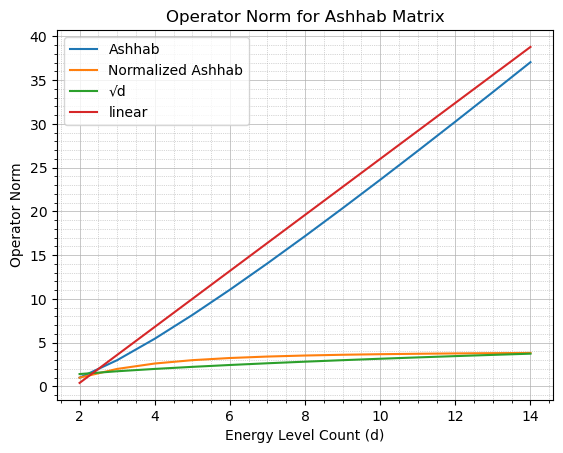

In [22]:
import matplotlib.pyplot as plt
plt.style.use('default')

elevels = np.array([int(i) for i in range(2,15)])
norms = [OpNorm(e) for e in elevels]
roots = [np.sqrt(e) for e in elevels]
squares = [e ** 2 for e in elevels]

plt.plot(elevels,norms)
plt.plot(elevels,roots)
plt.plot(elevels,3.2*elevels - 6)

plt.xlabel("Energy Level Count (d)")
plt.ylabel("Operator Norm")
plt.title("Operator Norm for Ashhab Matrix")
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle='dotted', linewidth='0.5')
plt.minorticks_on()
plt.legend(["Ashhab","Normalized Ashhab","\u221Ad","linear"])
plt.savefig(os.path.join(os.getcwd(),"Figures/","CNOT_Diagonals.pdf"), format="pdf")

In [17]:
import numpy as np 
level = 2
H0 = np.ones([level ** 2, level ** 2])
for i in range(level ** 2):
    H0[i,i] = 0
print(H0)

[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


In [2]:
import numpy as np
from numpy import array,kron
annhilate = array([[0,1,0],[0,0,np.sqrt(2)],[0,0,0]])
create = annhilate.T
H0 = kron(annhilate,create) + kron(create,annhilate)

print(H0)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.41421356 0.
  0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         1.41421356 0.         0.         0.
  1.41421356 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         2.         0.        ]
 [0.         0.         0.         0.         1.41421356 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         2.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]


# Analytical Speed-Limit Testing

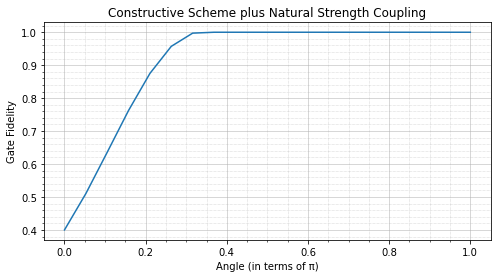

In [23]:
arr = np.linspace(0,pi/2,20)
arr = [val if val < pi/6 else pi/6 for val in arr]
arr

[0.0,
 0.08267349088394192,
 0.16534698176788384,
 0.24802047265182575,
 0.3306939635357677,
 0.4133674544197096,
 0.4960409453036515,
 0.5235987755982988,
 0.5235987755982988,
 0.5235987755982988,
 0.5235987755982988,
 0.5235987755982988,
 0.5235987755982988,
 0.5235987755982988,
 0.5235987755982988,
 0.5235987755982988,
 0.5235987755982988,
 0.5235987755982988,
 0.5235987755982988,
 0.5235987755982988]

In [171]:
from numpy import array,kron
annhilate = array([[0,1,0],[0,0,np.sqrt(2)],[0,0,0]])
create = annhilate.T
H0 = kron(annhilate + create,annhilate + create)

#Diagonal Entries 
diagEntries = [0, 5.440, 10.681, 4.994, 10.433, 15.666, 9.832, 15.270, 20.506]
for i,d in enumerate(diagEntries):
    H0[i,i] = d
for row in H0:
    for val in row:
        if val > 10:
            print(f"{val:.{1}f}",end=" ")
        else:
            print(f"{val:.{2}f}",end=" ")
    print()

0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 
0.00 5.44 0.00 1.00 0.00 1.41 0.00 0.00 0.00 
0.00 0.00 10.7 0.00 1.41 0.00 0.00 0.00 0.00 
0.00 1.00 0.00 4.99 0.00 0.00 0.00 1.41 0.00 
1.00 0.00 1.41 0.00 10.4 0.00 1.41 0.00 2.00 
0.00 1.41 0.00 0.00 0.00 15.7 0.00 2.00 0.00 
0.00 0.00 0.00 0.00 1.41 0.00 9.83 0.00 0.00 
0.00 0.00 0.00 1.41 0.00 2.00 0.00 15.3 0.00 
0.00 0.00 0.00 0.00 2.00 0.00 0.00 0.00 20.5 


In [176]:
t = 1.0
print(str(int(t)))

1


In [4]:
import numpy as np
from numpy import sqrt
H0 = np.zeros([3 ** 2, 3 ** 2])
H0[0,4] = 1
H0[2,4] = sqrt(2)
H0[6,4] = sqrt(2)
H0[8,4] = 2
H0 = H0 + H0.transpose()
for row in H0:
    for val in row:
        if val > 10:
            print(f"{val:.{1}f}",end=" ")
        else:
            print(f"{val:.{2}f}",end=" ")
    print()

0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 1.41 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.00 0.00 1.41 0.00 0.00 0.00 1.41 0.00 2.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 1.41 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 2.00 0.00 0.00 0.00 0.00 


In [16]:
from itertools import permutations
vals = [1,-1] * 4
negList = list(permutations(vals,8))
len(negList)

40320

In [55]:
from random import randint
vals = [1,-1] * 4
negList = list(permutations(vals,8))
perm = randint(0,len(negList))
print("The number of permutations is: " + str(len(negList)))
print("The selected permutation is: " + str(perm))
print("The corresponding permutation is: " + str(negList[perm]))
negs = negList[perm]
for n in negs:
    print(n)

The number of permutations is: 40320
The selected permutation is: 7274
The corresponding permutation is: (-1, 1, 1, 1, 1, -1, -1, -1)
-1
1
1
1
1
-1
-1
-1


In [15]:
import numpy as np
from numpy import sqrt
H0 = np.zeros([3 ** 2, 3 ** 2])
H0[0,4] = 1
H0[2,4] = sqrt(2)
H0[6,4] = sqrt(2)
H0[8,4] = 2

H0[4,0] = 1
H0[4,2] = sqrt(2)
H0[4,6] = sqrt(2)
H0[4,8] = 2

for row in H0:
    for val in row:
        if val > 10:
            print(f"{val:.{1}f}",end=" ")
        else:
            print(f"{val:.{2}f}",end=" ")
    print()

0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 1.41 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.00 0.00 1.41 0.00 0.00 0.00 1.41 0.00 2.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 1.41 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 2.00 0.00 0.00 0.00 0.00 


In [99]:
vals = [1,-1] * 2
negList = list(permutations(vals,4))
perm = randint(0,len(negList))
negs = negList[perm]
H0 = np.zeros([3 ** 2, 3 ** 2])

H0[0,4] = negs[0]*1
H0[2,4] = negs[1]*sqrt(2)
H0[6,4] = negs[2]*sqrt(2)
H0[8,4] = negs[3]*2

H0 = H0 + H0.transpose()
for row in H0:
        for val in row:
            if abs(val) > 10:
                if val < 0:
                     print(f"{val:.{0}f}",end=" ")
                else:
                    print(f"{val:.{1}f}",end=" ")
            else:
                if val < 0:
                     print(f"{val:.{1}f}",end=" ")
                else:
                    print(f"{val:.{2}f}",end=" ")
        print()

0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 -1.4 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.00 0.00 -1.4 0.00 0.00 0.00 1.41 0.00 -2.0 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 1.41 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 -2.0 0.00 0.00 0.00 0.00 


In [67]:
vals = [1,-1] * 2
negList = list(permutations(vals,4))
#perm = randint(0,len(negList))
for perm in range(len(negList)):
    negs = negList[perm]

    H0 = np.zeros([3 ** 2, 3 ** 2])

    H0[0,4] = negs[0]*1
    H0[2,4] = negs[1]*sqrt(2)
    H0[6,4] = negs[2]*sqrt(2)
    H0[8,4] = negs[3]*2

    H0 = H0 + H0.transpose()

    for row in H0:
        for val in row:
            if val > 10:
                print(f"{val:.{1}f}",end=" ")
            else:
                print(f"{val:.{2}f}",end=" ")
        print()
    print()

0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 -1.41 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.00 0.00 -1.41 0.00 0.00 0.00 1.41 0.00 -2.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 1.41 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 -2.00 0.00 0.00 0.00 0.00 

0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 -1.41 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
1.00 0.00 -1.41 0.00 0.00 0.00 -1.41 0.00 2.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 -1.41 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 2.00 0.00 0.00 0.00 0.00 

0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 1.41 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00

In [141]:
couplingType = "AnalyNeg" + str(randint(0,24))
if couplingType[:8] == "AnalyNeg":
    print(couplingType[8:])
print(couplingType)

4
AnalyNeg4
